# diffusion model project

Building a diffusion model based on the U-Net network from scratch, and using the Fashion-MNIST dataset for model training and sampling.

————2024/5/13



In [31]:
# !pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F



In [33]:

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

# Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
# original size (128,28,28,28), b=128 unchange, c is originally 28, which becomes (c p1 p2)=c*2*2=112, (h p1)=h*p1=28, h=14, w=14
# Parentheses indicate multiplication


In [34]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim # 28

    def forward(self, time):
        # time.shape=[128]
        # shape of time[:, None] = [128,1]
        
        device = time.device
        half_dim = self.dim // 2  # 14
        embeddings = math.log(10000) / (half_dim - 1) # float
        
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) # torch.Size([14])
        # shape of embeddings[None, :] = [1,14]
        
        embeddings = time[:, None] * embeddings[None, :] # [128,14]
        
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # [128,28]
        
        return embeddings



In [35]:

class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8): # groups=4
        # dim=28, dim_out=28, time_emb_dim=112
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) # 112， 28*2=56
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1) # Divide time_emb into 2 blocks vertically along dim=1

        h = self.block1(x, scale_shift=scale_shift) ##
        h = self.block2(h)
        return h + self.res_conv(x)



In [36]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        # dim=28
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads # 4
        hidden_dim = dim_head * heads # 32*4 =128
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False) # 28 128*3 

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)



In [37]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)



In [75]:
class Unet(nn.Module):
    def __init__(
        self,
        dim, # 28
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8), # （1，2，4，）
        channels=3, # 1
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels # 1
        self.self_condition = self_condition # false
        input_channels = channels * (2 if self_condition else 1) # 1

        init_dim = default(init_dim, dim) # 28
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) 
        # nn.Conv2d(input_channels=1, output_channel=28, kernal_size=1, padding=0)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [28, 28, 56, 112]
        in_out = list(zip(dims[:-1], dims[1:])) # [(28, 28), (28, 56), (56, 112)]

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4 # 28*4=112

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim), # output.shape=[128,28]
            nn.Linear(dim, time_dim), # output.shape=[128,112]
            nn.GELU(),
            nn.Linear(time_dim, time_dim),  # # output.shape=[128,112]
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out): 
            # Three rounds, first round dim_in=28 dim_out=28; second round: dim_in=28, dim_out=56, third round: dim_in=56, dim_out=112
            
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim), # 28 28 112
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim), # 28 28 112
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))), # 
                        Downsample(dim_in, dim_out) # 128 26 14 14
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        # The variable `x` with shape `[128, 1, 28, 28]` represents a batch of images. The images are first noised, then undergo forward propagation. 
        # The degree of noise is determined by the `timestep = time`, 
        # where `time` has shape `[128,]` and each element is a random number between 0 and 300.
        
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time) # # t.shape=[128,112]

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)



In [39]:

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    # Return a tensor with shape `[300]`, where `ans[0] = 0.0001`, `ans[-1] = 0.02`, increasing uniformly.
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start



In [40]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
# betas type: tensor shape=[300], betas[0]=0.0001, betas[-1]=0.02, uniform increase

# define alphas
alphas = 1. - betas # shape=[300],alphas[0] = tensor(0.9999), alphas[-1]=tensor(0.9800)
alphas_cumprod = torch.cumprod(alphas, axis=0)
# `alphas_cumprod` is the cumulative product of `alphas` with shape `[300]`. `alphas_cumprod` decreases faster compared to `alphas`.

alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# It is equivalent to removing the last element of `alphas_cumprod` and adding the element 1 at the beginning to get `alphas_cumprod_prev` with shape `[300]`.
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # shape=[300]


# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0] # 64
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
# len(x_shape)=4,
# out shape=[batch_size,1,1,1]


In [41]:

from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape HWC
print(image)



<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x17EACC850>


In [ ]:
image

In [44]:

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

x_start = transform(image).unsqueeze(0)
x_start.shape



torch.Size([1, 3, 128, 128])

In [45]:

import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])


In [46]:
# Forward noising process

# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise



In [47]:

def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image


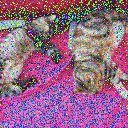

In [48]:

# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)



In [49]:

import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()



In [50]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])



In [51]:

def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    # x_start is a batch of images, shape=[128,1,28,28]
    # batch-size=128
    # t is a tensor with shape=[128,], each element is a random number between 0~300
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    # denoise_model is Unet model
    # Input the noised images and the timestep, and predict this noise.
    
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss



In [52]:

from datasets import load_dataset

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128



In [53]:

from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)



In [54]:

batch = next(iter(dataloader))
print(batch.keys())



dict_keys(['pixel_values'])


In [55]:
# This `p_sample` function is used during the denoising process for sampling after the model is trained.

@torch.no_grad()
def p_sample(model, x, t, t_index):
    # x shape:[64,1,28,28], t_index is current timestep, range is 299～0，299 is the first step of denoising, and 0 is the cleaned image
    # t=torch.full((b,), i, device=device, dtype=torch.long), b=batch_size=64, i=t_index
    # t is tensor with shape = [64,]
    
    betas_t = extract(betas, t, x.shape) # betas shape=[300], t.shape=[64,], x.shape=[64,1,28,28]
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0] # 64, batch_size
    
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device) # img shape = [64,1,28,28]
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs
# # imgs shape [300,64,1,28,28], timesteps=300, batch_size=28,channels=1,imag_size=28


@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3): 
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size)) # shape =[64,1,28,28]


In [56]:

from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./SD_DDPM_my02_results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000



In [78]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size, # 28
    channels=channels, # 1
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)



cpu


In [79]:
model

Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=56, bias=True)
        )
        (block1): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
   

Local train is quite slow. .

Run locally, comment out the following cell, and load the trained weights directly.

In [30]:

from torchvision.utils import save_image

epochs = 6

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        # Note that `t` has a shape of `[300]`, with each element being a random integer between 0 and 299. 
        # A batch of images consists of 128 images, but each image may correspond to a different `t`.

        loss = p_losses(model, batch, t, loss_type="huber")
        # batch-size=128
    
        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

#       # save generated images
#       if step != 0 and step % save_and_sample_every == 0:
#         milestone = step // save_and_sample_every
#         batches = num_to_groups(4, batch_size)
#         all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
#         all_images = torch.cat(all_images_list, dim=0)
#         all_images = (all_images + 1) * 0.5
#         save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)


Loss: 0.3897708058357239
Loss: 0.06382094323635101


KeyboardInterrupt: 

In [59]:

epochs = 6
model.load_state_dict(torch.load(f"./weights/model_{epochs}.pth", map_location=device))


<All keys matched successfully>

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

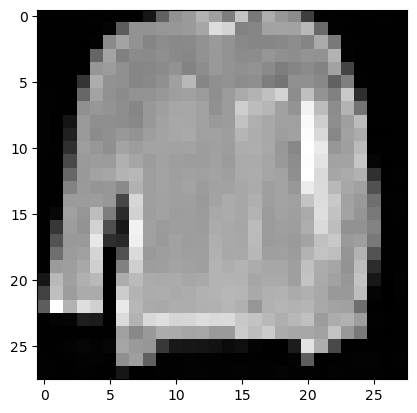

In [60]:
image_size=28
channels=1

# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)
# samples shape [300,64,1,28,28], timesteps=300, batch_size=28,channels=1,imag_size=28

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")



In [74]:


# # show a random one
# random_index = 5
# plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

nums=64
print(len(samples)) # 300, timesteps=300，A pure noise image undergoes 300 steps of sampling to obtain a clean image.
print(len(samples[0])) # 64，
print(len(samples[0][0]))
print(type(samples[0][0]))
print(samples[0][0].shape)

# show 4 images:
plt.figure()
for i in range(1, nums+1):
    plt.subplot(8, 8,i)
    plt.imshow(samples[-1][i-1].reshape(image_size, image_size, channels), cmap="gray")
plt.show()

300
64
1
<class 'numpy.ndarray'>
(1, 28, 28)


In [38]:
# show the gif,

# import matplotlib.animation as animation

# import matplotlib.pyplot as plt


# random_index = 53

# fig = plt.figure()
# ims = []
# for i in range(timesteps):
#     im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
#     ims.append([im])

# animate = animation.ArtistAnimation(fig, ims, interval=50,  repeat_delay=1000) # blit=True,
# animate.save('diffusion.gif',writer='pillow')
# plt.show()



refer: https://huggingface.co/blog/annotated-diffusion

In [ ]:
# the structure of the unet model

'''
Unet(
  (init_conv): Conv2d(1, 28, kernel_size=(1, 1), stride=(1, 1))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=28, out_features=112, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=112, out_features=112, bias=True)
  )
  (downs): ModuleList(
    (0~2): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=56, bias=True)
        )
        (0~1)(block): Block(
          (proj): WeightStandardizedConv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
        (fn): PreNorm(
          (fn): LinearAttention(
            (to_qkv): Conv2d(28, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (to_out): Sequential(
              (0): Conv2d(128, 28, kernel_size=(1, 1), stride=(1, 1))
              (1): GroupNorm(1, 28, eps=1e-05, affine=True)
            )
          )
          (norm): GroupNorm(1, 28, eps=1e-05, affine=True)
        )
      )
      (3): Sequential(
        (0): Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        (1): Conv2d(112, 28, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  (ups): ModuleList(
    (0~2): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=112, out_features=224, bias=True)
        )
        (0~1)(block): Block(
          (proj): WeightStandardizedConv2d(168, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 112, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(168, 112, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): Residual(
        (fn): PreNorm(
          (fn): LinearAttention(
            (to_qkv): Conv2d(112, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (to_out): Sequential(
              (0): Conv2d(128, 112, kernel_size=(1, 1), stride=(1, 1))
              (1): GroupNorm(1, 112, eps=1e-05, affine=True)
            )
          )
          (norm): GroupNorm(1, 112, eps=1e-05, affine=True)
        )
      )
      (3): Sequential(
        (0): Upsample(scale_factor=2.0, mode='nearest')
        (1): Conv2d(112, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  (0~1)(mid_block): ResnetBlock(
    (mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=112, out_features=224, bias=True)
    )
    (0~1)(block): Block(
      (proj): WeightStandardizedConv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): GroupNorm(4, 112, eps=1e-05, affine=True)
      (act): SiLU()
    )
    (res_conv): Identity()
  )
  (mid_attn): Residual(
    (fn): PreNorm(
      (fn): Attention(
        (to_qkv): Conv2d(112, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (to_out): Conv2d(128, 112, kernel_size=(1, 1), stride=(1, 1))
      )
      (norm): GroupNorm(1, 112, eps=1e-05, affine=True)
    )
  )
  (final_res_block): ResnetBlock(
    (mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=112, out_features=56, bias=True)
    )
    (0~1)(block): Block(
      (proj): WeightStandardizedConv2d(56, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): GroupNorm(4, 28, eps=1e-05, affine=True)
      (act): SiLU()
    )
    (res_conv): Conv2d(56, 28, kernel_size=(1, 1), stride=(1, 1))
  )
  (final_conv): Conv2d(28, 1, kernel_size=(1, 1), stride=(1, 1))
)


'''